In [1]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [2]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../best_model.pt',map_location='cpu'))
model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()

In [3]:
ids = get_courtney_ids()
all_metrics = pd.DataFrame()

In [4]:
X,y = load_courtney(ids[0])

WARNING *** file size (1897543) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
dataloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)

In [6]:
X,y = next(iter(dataloader))

In [7]:
loss,metrics,y_true,y_pred,logits = evaluate(dataloader,model,criterion,DEVICE)

  0%|          | 0/1080 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 1080/1080 [00:41<00:00, 25.75it/s]


In [34]:
metrics

{'precision': 0.824038662243794,
 'recall': 0.8840996382648978,
 'f1': 0.8475296162776598}

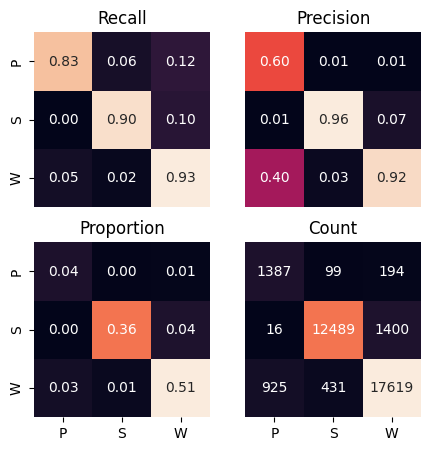

In [8]:
cm_grid(y_true,y_pred)

In [ ]:

# all_metrics = pd.concat([all_metrics,pd.Series(metrics,name=f'{filename}')],axis=1)

In [11]:
y_true.dtype

torch.float32

In [26]:
def get_bout_statistics_for_predictions(pred):
    if pred.dtype is torch.float32:
        pred = pd.DataFrame(pred)
        pred.loc[pred[0] == 2,0] = 'W'
        pred.loc[pred[0] == 1,0] = 'S'
        pred.loc[pred[0] == 0,0] = 'P'
        pred = pred[0]
    bout_lengths = {
    'P':[],
    'S':[],
    'W':[],
    'X':[],
    'A':[]
    }
    transition_matrix = pd.DataFrame(np.zeros((5,5)),columns=['P','S','W','X','A'],index=['P','S','W','X','A'])

    current_state = 'A'
    current_length = 0
    for epoch in pred:
        transition_matrix.loc[current_state,epoch] += 1
        if(epoch != current_state):
            bout_lengths[current_state].append(current_length)
            current_state = epoch
            current_length = 0
        current_length += 1
    bout_lengths[current_state].append(current_length)
    bout_lengths.pop('X')
    bout_lengths.pop('A')
    total = {key:sum(bout_lengths[key])*10/60 for key in bout_lengths}
    average = {key:np.mean(bout_lengths[key])*10 for key in bout_lengths}
    counts = {key:len(bout_lengths[key]) for key in bout_lengths}
    
    return pd.DataFrame([pd.Series(total,name='total'),pd.Series(average,name='average'),pd.Series(counts,name='counts')])

In [30]:
stats = get_bout_statistics_for_predictions(y_true)
stats

,P,S,W
total,280.000000,2317.500000,3162.500000
average,58.536585,126.065277,180.028463
counts,287.000000,1103.000000,1054.000000


In [29]:
stats = get_bout_statistics_for_predictions(y_pred)
stats

,P,S,W
total,388.000000,2169.833333,3202.166667
average,69.285714,90.978337,133.146223
counts,336.000000,1431.000000,1443.000000


In [31]:
import plotly.express as px
fig = px.line(data_frame=pd.DataFrame([y_pred.numpy(),y_true.numpy()]).T)
fig.show(renderer='browser')

In [ ]:
for filename in ids:
    print(filename)
    if filename == '22-Oct-A':
        continue
    fs = 500
    raw = read_raw_edf((f'../data/courtney_aug_oct_2022_baseline_recordings/1_raw_edf/{filename}.edf'),verbose=False)
    measurement_date = raw.info["meas_date"]
    eeg = raw.get_data(picks='EEG 1')[0]
    df = pd.read_excel(f'../data/courtney_aug_oct_2022_baseline_recordings/2_labels/CW {filename} Baseline.xls')
    df = df.drop(0).reset_index(drop=True)
    df = fix_gaps(df)
    df.loc[df['Label'] == 'X','Label'] = NA
    df = df.fillna(method='ffill')
    print(df['Start Time'].diff().value_counts())
    print(df['Label'].value_counts())
    start_time = df['Start Time'][0]
    end_time = df.iloc[-1,0]
    length = (end_time - start_time)
    times = [start_time + datetime.timedelta(seconds=10*i) for  i in range(int((length.days*86400 + length.seconds)/10)+1)]
    print(len(times))
    print(times[0])
    print(times[-1])
    eeg = raw.get_data(picks='EEG 1')[0]
    print(eeg.shape[0]/500)
    measurement_date = measurement_date.replace(tzinfo=None)
    offset = df.iloc[0,0] - measurement_date
    eeg = eeg[offset.seconds*500:]
    print(eeg.shape[0]/500)
    eeg = eeg[:len(times)*5000]
    print(eeg.shape[0]/500)
    eeg = from_numpy(eeg.reshape(-1, 5000)).float()
    print(eeg.shape)
    y = one_hot(from_numpy(Categorical(df['Label']).codes.copy()).long()).float()
    dataloader = DataLoader(Windowset(eeg,y),batch_size=32,shuffle=False)
    loss,metrics,y_true,y_pred,logits = evaluate(dataloader,model,criterion,DEVICE)
    all_metrics = pd.concat([all_metrics,pd.Series(metrics,name=f'{filename}')],axis=1)